In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import solve_banded
from matplotlib import pyplot as plt

# Лабораторная работа 4

## Нелинейная краевая задача

### Постановка задачи

$$ y'' - x \sqrt{y} = 0, \space 0 \leq x \leq 1; $$

$$ y(0) = 0, \space y(1) = 2. $$

## Метод стрельбы

Пусть дана краевая задача:

$$ y'' = f(x, y, y'), \space 0 < x < 1, $$

$$ y(0) = Y_0, \space y(1) = Y_1. $$

Рассмотрим задачу Коши:

$$ y'' = f(x, y, y'), \space 0 < x < 1, $$

$$ y(0) = Y_0, $$

$$ y'(0) = \alpha, $$

где $Y_0$ - ордината точки $(0, Y_0)$, из которой выходит интегральная кривая; $\alpha$ - пристрелочный параметр. При $x = 1$ решение $y(x, \alpha)$ зависит только от $\alpha$:

$$ y(x, \alpha)|_{x=1} = y(1, \alpha). $$

Можно найти параметр $\alpha = \alpha^*$, при котором интегральная кривая, выходящая из точки $(0, Y_0)$, попадает в точку $(1, Y_1)$:

$$ y(1, \alpha) = Y_1. $$

Таким образом, задача свелась к следующей:

$$ F(\alpha) = 0, $$

где $F(\alpha) = y(1, \alpha) - Y_1.$

$$ y''(x, \alpha) = f(x, y(x, \alpha), y'(x, \alpha)), $$

$$ \frac{\partial}{\partial \alpha} y''(x, \alpha) = \frac{\partial}{\partial y} f(x, y(x, \alpha), y'(x, \alpha)) \frac{\partial y}{\partial \alpha} + \frac{\partial}{\partial y'} f(x, y(x, \alpha), y'(x, \alpha)) \frac{\partial y'}{\partial \alpha}. $$

$$ \left(\frac{\partial y}{\partial \alpha}\right)'' = \frac{\partial f}{\partial y} \frac{\partial y}{\partial \alpha} + \frac{\partial f}{\partial y'} \frac{d}{dx} \frac{\partial y}{\partial \alpha}. $$

Пусть $u = \frac{\partial y}{\partial \alpha}$. Тогда она определяется линейным уравнением в вариациях

$$ u'' = \frac{\partial f}{\partial y} u + \frac{\partial f}{\partial y'} u', $$

для которого необходимо задать начальные условия:

$ u(0) = 0, \space u'(0) = 1. $

In [4]:
# Boundary conditions
Y0 = 0.0
Y1 = 2.0
X0 = 0.0
X1 = 1.0

def system_odes(x, S_vec):
    y_s, yp_s, u_s, up_s = S_vec

    if y_s < 0:
        y_s_for_sqrt = 0.0
    else:
        y_s_for_sqrt = y_s
    
    sqrt_y_s_val = np.sqrt(y_s_for_sqrt)

    dydx = yp_s
    dypdx = x * sqrt_y_s_val

    dudx = up_s
    
    if x == 0:
        dfdy = 0.0
    elif y_s_for_sqrt < 1e-12:
        dfdy = 1e12
    else:
        dfdy = x / (2 * sqrt_y_s_val)
        
    dupdx = dfdy * u_s
    
    return [dydx, dypdx, dudx, dupdx]

alpha_current = 1

tol = 1e-8
max_iter = 25
iteration_history = []

for i in range(max_iter):
    iteration_history.append({'alpha': alpha_current})

    S0_system = [Y0, alpha_current, 0.0, 1.0]

    sol = solve_ivp(system_odes, [X0, X1], S0_system, dense_output=True, atol=1e-10, rtol=1e-10)

    y_at_X1 = sol.sol(X1)[0]
    u_at_X1 = sol.sol(X1)[2] # Это F'(alpha)
        
    F_alpha = y_at_X1 - Y1
    F_prime_alpha = u_at_X1

    iteration_history[-1]['y(1,alpha)'] = y_at_X1
    iteration_history[-1]['F(alpha)'] = F_alpha
    iteration_history[-1]["F'(alpha)"] = F_prime_alpha
    
    if abs(F_alpha) < tol:
        alpha_optimal = alpha_current
        break

    alpha_new = alpha_current - F_alpha / F_prime_alpha
    
    alpha_current = alpha_new

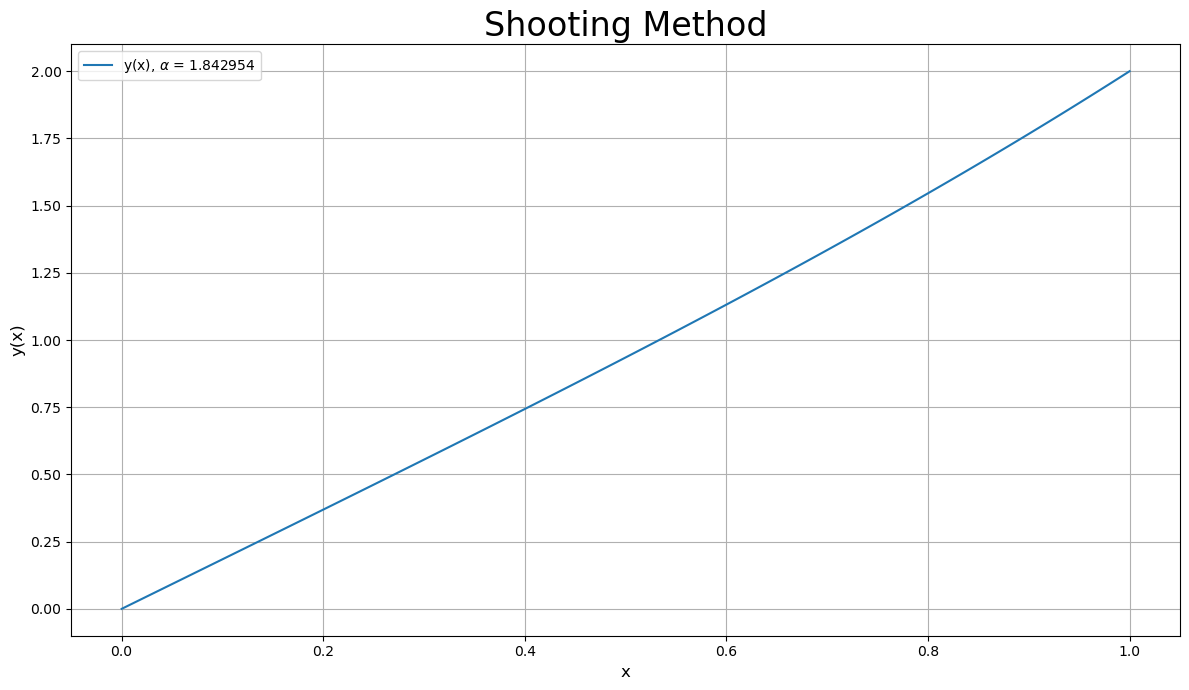

In [5]:
S0_optimal = [Y0, alpha_optimal, 0, 1]

sol_optimal = solve_ivp(system_odes, [X0, X1], S0_optimal, 
                        dense_output=True, t_eval=np.linspace(X0, X1, 101),
                        atol=1e-10, rtol=1e-10)

plt.figure(figsize=(12, 7))
plt.plot(sol_optimal.t, sol_optimal.y[0], label=f'y(x), $\\alpha$ = {alpha_optimal:.6f}')
plt.xlabel('x', fontsize=12)
plt.ylabel('y(x)', fontsize=12)
plt.title(f"Shooting Method", fontsize=24)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Метод квазилинеаризации Ньютона

Пусть дана краевая задача:

$$ y'' = f(x, y, y'), \space 0 < x < 1, $$

$$ y(0) = Y_0, \space y(1) = Y_1. $$

Допустим, для неё известна функция $y_0(x)$, удовлетворяющая граничным условиям и грубо приближённо равная искомому $y(x)$. Пусть:

$$ y(x) = y_0(x) + v(x), $$

где $v(x)$ - поправка к нулевому приближению $y_0(x)$.

$$ y''(x) = y_0''(x) + v''(x), $$

$$ f(x, y_0 + v, y_0' + v') = f(x, y_0, y_0') + \frac{\partial f(x, y_0, y_0')}{\partial y} v + \frac{\partial f(x, y_0, y_0')}{\partial y'} v' + O(v^2 + |v'|^2). $$


Отбросив $O(v^2 + |v'|^2)$, получим линейную краевую задачу для нахождения поправки $\tilde{v}$ с нулевыми краевыми условиями:

$$ \tilde{v}'' = p(x) \tilde(v)' + q(x) \tilde(v) + r(x), $$

$$ \tilde(v)(0) = 0, \space \tilde(v)(1) = 0, $$

где

$$ p(x) = \frac{\partial f(x, y_0, y_0')}{\partial y'}, \space q(x) = \frac{\partial f(x, y_0, y_0')}{\partial y}, $$

$$ r(x) = f(x, y_0, y_0') - y_0''. $$

Решая полученную краевую задачу каким-либо численным методом, найдём поправку $\tilde{v}$ и примем за первое приближение

$$ y_1(x) = y_0(x) + \tilde{v}. $$

Аналогично, зная $y_1(x)$, положим $y(x) = y_1(x) + \tilde{v}_1$ и найдём следующее приближение. Для него будем решать то же уравнение 
в вариациях, но с коэффициентами  вычисленными по первому приближению, и с правой частью-– невязкой первого приближения  Продолжая процесс до тех пор, пока не будут выполнены неравенств

$$ \max{|\tilde{v}(x)|} \leq \varepsilon, \space x \in [0, 1], $$

где $\varepsilon$ - требуемая точность, найдем приближенное решение исходной нелинейной задачи.а

In [7]:
# Boundary conditions
X0, X1 = 0.0, 1.0
Y0, Y1 = 0.0, 2.0

N = 100
h = (X1 - X0) / N
x_grid = np.linspace(X0, X1, N + 1)

max_iterations = 50
tolerance = 1e-8
epsilon = 1e-12

y_current = Y0 + (Y1 - Y0) * (x_grid - X0) / (X1 - X0)

iteration_history = []
y_history = [y_current.copy()]

for k in range(max_iterations):
    x_internal = x_grid[1:-1]
    y_internal = y_current[1:-1]

    y_internal_safe_sqrt = np.sqrt(np.maximum(epsilon, y_internal))
    
    rhs_b = np.zeros(N - 1)
    for i in range(N - 1):
        y_val_at_xi = y_internal[i]
        y_prev_for_ypp = y_current[i]
        y_next_for_ypp = y_current[i+2]

        rhs_b[i] = h**2 * x_internal[i] * y_internal_safe_sqrt[i] - \
                   (y_prev_for_ypp - 2 * y_val_at_xi + y_next_for_ypp)
    
    ab = np.zeros((3, N - 1))
    
    diag_coeff = - (h**2 * x_internal) / (2 * y_internal_safe_sqrt)
    ab[1, :] = -2.0 + diag_coeff 
    
    ab[2, 1:] = 1.0 
    
    ab[0, :-1] = 1.0
    
    v_internal = solve_banded((1, 1), ab, rhs_b)

    v_correction = np.zeros(N + 1)
    v_correction[1:-1] = v_internal
    
    max_v = np.max(np.abs(v_correction))
    iteration_history.append({'k': k, 'max_v': max_v, 'y_at_1': y_current[N]})

    if max_v < tolerance:
        y_solution = y_current + v_correction
        y_solution[0] = Y0
        y_solution[N] = Y1
        y_history.append(y_solution.copy())
        break
    
    y_next = y_current + v_correction
     
    y_current = y_next
    y_current[0] = Y0
    y_current[N] = Y1
    y_history.append(y_current.copy())

else:
    y_solution = y_current

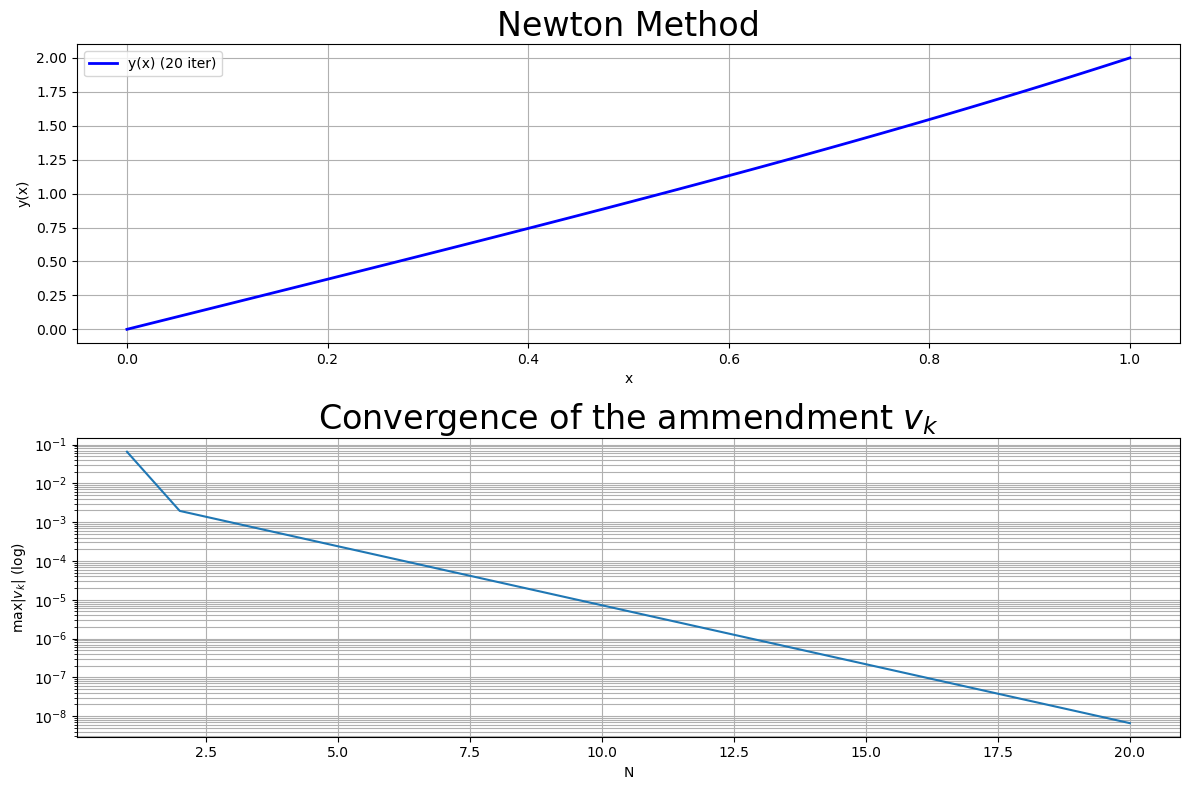

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(x_grid, y_solution, label=f'y(x) ({len(y_history)-1} iter)', color='b', linewidth=2)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title("Newton Method", fontsize=24)
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
iters = [item['k'] + 1 for item in iteration_history]
max_vs = [item['max_v'] for item in iteration_history]
plt.plot(iters, max_vs)
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('$\\max{|v_k|}$ (log)')
plt.title('Convergence of the ammendment $v_k$', fontsize=24)
plt.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()